In [1]:
#Ode Solver
from qutip import *
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from odeintw import odeintw



import math
import random
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from numpy import linalg as LA
import copy
import time
import gc
%load_ext memory_profiler

In [2]:
import sys
sys.path.append('../Überarbeitung/.')
from init_atoms import *

In [3]:
def auswertung(probability):
    
    distance_matrix= scipy.spatial.distance.cdist(atoms_array, atoms_array, metric='euclidean')  
    abstand_ursprung = copy.copy(distance_matrix[:,0])
        
    # Mean square und mean displacement---------------------------------------------------------------------
    r_2=np.dot(probability,np.power(abstand_ursprung,2))
    r_1=np.dot(probability,abstand_ursprung)
    
    
    #standard deviation -----------------------------------------------------------------------------------
    deviation=np.subtract(r_2,np.square(r_1))
    
    
    ipr=1/np.sum(probability**2,axis=1)
    
        
    n_intervall_inf =[]
    density_inf=[]
    density=[]
    
    d_r = int(2*r_b)
    for i in range(0,int(radius-d_r),d_r):
        flaeche= np.pi*((i+d_r)**2-i**2)
        index = np.argwhere((i<=abstand_ursprung)& (abstand_ursprung<i+d_r))
        
        n_intervall_inf.append((np.sum(probability[-1][index]))/(flaeche))
            
        laenge= len(index)
        if laenge==0:
            density_inf.append(0)
            density.append(0)
        else:
            density_inf.append(np.sum(probability[-1][index])/len(index))
            density.append(np.sum(probability[50][index])/len(index))

   
    #distribution_width---------------------------------------------------------------------------------

    
    inhalt=0
    global distribution_width
    distribution_width=[]
    
    for i in range(0,len(probability)):
        tmp=copy.copy(abstand_ursprung)
        inhalt=0
        while inhalt<0.9:
            minimum= np.argmin(tmp)
            kk= abstand_ursprung[minimum]
            inhalt+= probability[i][minimum]
            tmp[minimum]=math.inf
        distribution_width.append(kk)
    
    
    return np.array(r_1),np.array(r_2), np.array(density), np.array(density_inf),np.array(ipr),np.array(n_intervall_inf), np.array(deviation), np.array(distribution_width)

#### Funktionen für exakte Diagonalisierung

In [4]:
def generate_hamiltonian(atoms):
    number_atoms=len(atoms)
    
    #Distance + Hamiltonian-------------------------------------------------------------------------------------
    H = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    global distance_matrix
    distance_matrix = np.zeros((number_atoms,number_atoms),dtype=np.float16)
    
    
    #start= time.time()
    distance_matrix= scipy.spatial.distance.cdist(atoms, atoms, metric='euclidean')
    np.fill_diagonal(distance_matrix,1)
    H=np.divide(coupling_constant,np.power(distance_matrix,3))
    np.fill_diagonal(distance_matrix,0)
    np.fill_diagonal(H,0)
    #print("Time for Hamiltonian: ",time.time()-start)
    
    
    global abstand_ursprung
    abstand_ursprung= np.zeros(number_atoms, dtype=np.float16)
    abstand_ursprung = copy.copy(distance_matrix[:,angeregt])
    
#Linearisierung---------------------------------------------------------------------------------------------
    #start = time.time()
    global eigenvalues
    eigenvalues=np.zeros(number_atoms,dtype=np.float16)
    global eigenvectors2
    eigenvectors=np.zeros((number_atoms,number_atoms),dtype=np.float16)
    eigenvalues, eigenvectors = LA.eigh(H)
    eigenvectors2=copy.copy(eigenvectors)
    #print("Time for Linearisierung: ",time.time()-start)

    return eigenvalues, eigenvectors,H

In [5]:
def ultimate_justeins(eigen_values,eigenvectors,times_tmp,angeregt):
    
    total_steps=len(times_tmp)
#Zeitenwicklung--------------------------------------------------------------------------------------------
    #start = time.time()
    projection=eigenvectors[angeregt]
    psi_t= np.zeros((total_steps,number_atoms,1),dtype="complex64")
    for i,t in enumerate(times_tmp):
        psi_t[i]= (eigenvectors @ (np.exp(-1j*eigenvalues*t)*projection))[:,None]
        
    #print("Time for Probability_Zeitentwicklung: ",time.time()-start)
    
    #komplette Zeitenwicklung ohne Schleife, aber leider langsamer:
            #psi_t2= ((eigenvectors*np.exp(-1j*eigen_values*times_tmp[:,None])[:,None])@projection)[:,:,None]
    
    
#Wahrscheinlichkeiten---------------------------------------------------------------------------------------
    #start = time.time()
    np.square(np.absolute(psi_t,out=psi_t),out=psi_t)    # now psi_all_t = probability
    #print("Time for Probability_wahrscheinlichkeit: ",time.time()-start)

    probability=np.real(psi_t)
  
    psi_t = None
    gc.collect()
    
    
    return probability

In [6]:
def Berechnung(eigenvalues,eigenvectors,number_atoms,time_array):  
    
    probability = np.zeros((1,number_atoms,1))
    anzahl_steps_möglich =  math.floor(1000000000/(number_atoms*number_atoms))
    # Restriction for each PC for how many time steps it can handel
    
    global runden
    ang_anzahl_steps=round(len(time_array))
    runden = math.floor((ang_anzahl_steps-1)/anzahl_steps_möglich)

    start=time.time()

    for i in range(runden):
        times_tmp = time_array[i*anzahl_steps_möglich:(i+1)*anzahl_steps_möglich]
        
        prob_tmp = ultimate_justeins(eigenvalues,eigenvectors,times_tmp,angeregt)
        probability=np.append(probability,prob_tmp,axis=0)
    
    times_tmp = time_array[runden*anzahl_steps_möglich:]
    
    prob_tmp = ultimate_justeins(eigenvalues,eigenvectors,times_tmp,angeregt)
    probability=np.append(probability,prob_tmp,axis=0)
        

       
    probability=np.delete(probability,0,axis=0)
                         
    return probability

#### Atoms und Hamiltonian für Lösen der Master equation

In [12]:
global coupling_constant
coupling_constant= 2.72*10**9
number_atoms = 5    
r_b=2.5   
density=0.1
radius = (np.sqrt(number_atoms*r_b**2/density))

## Mehrere aufeinmal

In [8]:
def ME(t, rho):
    rho=rho.reshape((number_atoms,number_atoms))
    terms=copy.copy(rho)
    np.fill_diagonal(terms,0)
    return np.ravel(-1j*(np.dot(H, rho)- np.dot(rho, H)) -gamma*terms)


index=2
diss_khz=np.array([10,50,100])
gamma_khz=diss_khz[index]
gamma=gamma_khz*10**3*2*np.pi

times_exact=np.logspace(-8,-3,100)
times=np.logspace(-8,-4,100)

iterations=3

In [111]:
angeregt=0
global gamma
global number_atoms
global atoms_array
global H


start1=time.time()

atoms_array = produce_atoms(number_atoms,radius,r_b)

#exakt
eigenvalues, eigenvectors,H = generate_hamiltonian(atoms_array)
prob_exact=Berechnung(eigenvalues,eigenvectors,number_atoms,times_exact).squeeze()

#Mastereq
initial=np.zeros((number_atoms,number_atoms), dtype=complex)
initial[0][0]=1
results = solve_ivp(ME, [0,times[-1]],initial.ravel(), t_eval=times,rtol=1e-4, atol=1e-6) 
prob_diss=np.reshape(results.y,(number_atoms,number_atoms, len(times))).diagonal()


r_1_normal,r_2_normal, density_normal, density_inf_normal,ipr_normal, n_intervall_inf_normal, deviation_normal, distribution_width_normal=auswertung(prob_exact)
r_1_diss,r_2_diss, density_diss, density_inf_diss,ipr_diss, n_intervall_inf_diss, deviation_diss, distribution_width_diss=auswertung(prob_diss)  

r_1_normal_S=0
r_2_normal_S=0 
density_normal_S=0 
density_inf_normal_S=0
ipr_normal_S=0 
n_intervall_inf_normal_S=0 
deviation_normal_S=0 
distribution_width_normal_S=0

r_1_diss_S=0
r_2_diss_S=0 
density_diss_S=0 
density_inf_diss_S=0
ipr_diss_S=0 
n_intervall_inf_diss_S=0 
deviation_diss_S=0 
distribution_width_diss_S=0 


for i in range(0,iterations-1):
    atoms_array = produce_atoms(number_atoms,radius,r_b)
    
    #exakt
    eigenvalues, eigenvectors,H = generate_hamiltonian(atoms_array)
    prob_exact=Berechnung(eigenvalues,eigenvectors,number_atoms,times_exact).squeeze()

    #Mastereq
    initial=np.zeros((number_atoms,number_atoms), dtype=complex)
    initial[0][0]=1
    results = solve_ivp(ME, [0,times[-1]],initial.ravel(), t_eval=times,rtol=1e-4, atol=1e-6) 
    prob_diss=np.reshape(results.y,(number_atoms,number_atoms, len(times))).diagonal()

    
    r_1_normal_tmp,r_2_normal_tmp, density_normal_tmp, density_inf_normal_tmp,ipr_normal_tmp, n_intervall_inf_normal_tmp, deviation_normal_tmp, distribution_width_normal_tmp=auswertung(prob_exact)
    r_1_diss_tmp,r_2_diss_tmp, density_diss_tmp, density_inf_diss_tmp,ipr_diss_tmp, n_intervall_inf_diss_tmp, deviation_diss_tmp, distribution_width_diss_tmp=auswertung(prob_diss)  

    r_1_normal_prev = r_1_normal
    r_2_normal_prev =  r_2_normal
    density_normal_prev =  density_normal
    density_inf_normal_prev = density_inf_normal
    ipr_normal_prev =  ipr_normal
    n_intervall_inf_normal_prev =  n_intervall_inf_normal
    deviation_normal_prev =  deviation_normal
    distribution_width_normal_prev = distribution_width_normal
    
    r_1_diss_prev = r_1_diss
    r_2_diss_prev =  r_2_diss
    density_diss_prev =  density_diss
    density_inf_diss_prev = density_inf_diss
    ipr_diss_prev =  ipr_diss
    n_intervall_inf_diss_prev =  n_intervall_inf_diss
    deviation_diss_prev =  deviation_diss
    distribution_width_diss_prev = distribution_width_diss
    
    r_1_normal = (r_1_normal*(i+1)+r_1_normal_tmp)/(i+2)
    r_2_normal =  (r_2_normal*(i+1)+r_2_normal_tmp)/(i+2)
    density_normal =  (density_normal*(i+1)+density_normal_tmp)/(i+2)
    density_inf_normal = (density_inf_normal*(i+1)+density_inf_normal_tmp)/(i+2)
    ipr_normal =  (ipr_normal*(i+1)+ipr_normal_tmp)/(i+2)
    n_intervall_inf_normal =  (n_intervall_inf_normal*(i+1)+n_intervall_inf_normal_tmp)/(i+2)
    deviation_normal =  (deviation_normal*(i+1)+deviation_normal_tmp)/(i+2)
    distribution_width_normal = (distribution_width_normal*(i+1)+distribution_width_normal_tmp)/(i+2)

    r_1_diss = (r_1_diss*(i+1)+r_1_diss_tmp)/(i+2)
    r_2_diss =  (r_2_diss*(i+1)+r_2_diss_tmp)/(i+2)
    density_diss =  (density_diss*(i+1)+density_diss_tmp)/(i+2)
    density_inf_diss = (density_inf_diss*(i+1)+density_inf_diss_tmp)/(i+2)
    ipr_diss =  (ipr_diss*(i+1)+ipr_diss_tmp)/(i+2)
    n_intervall_inf_diss =  (n_intervall_inf_diss*(i+1)+n_intervall_inf_diss_tmp)/(i+2)
    deviation_diss =  (deviation_diss*(i+1)+deviation_diss_tmp)/(i+2)
    distribution_width_diss = (distribution_width_diss*(i+1)+distribution_width_diss_tmp)/(i+2)

    r_1_normal_S += (r_1_normal_tmp-r_1_normal)*(r_1_normal_tmp-r_1_normal_prev)
    r_2_normal_S +=  (r_2_normal_tmp-r_2_normal)*(r_2_normal_tmp-r_2_normal_prev)
    density_normal_S +=  (density_normal_tmp-density_normal)*(density_normal_tmp-density_normal_prev)
    density_inf_normal_S += (density_inf_normal_tmp-density_inf_normal)*(density_inf_normal_tmp-density_inf_normal_prev)
    ipr_normal_S +=  (ipr_normal_tmp-ipr_normal)*(ipr_normal_tmp-ipr_normal_prev)
    n_intervall_inf_normal_S +=  (n_intervall_inf_normal_tmp-n_intervall_inf_normal)*(n_intervall_inf_normal_tmp-n_intervall_inf_normal_prev)
    deviation_normal_S +=  (deviation_normal_tmp-deviation_normal)*(deviation_normal_tmp-deviation_normal_prev)
    distribution_width_normal_S += (distribution_width_normal_tmp-distribution_width_normal)*(distribution_width_normal_tmp-distribution_width_normal_prev)

    r_1_diss_S += (r_1_diss_tmp-r_1_diss)*(r_1_diss_tmp-r_1_diss_prev)
    r_2_diss_S +=  (r_2_diss_tmp-r_2_diss)*(r_2_diss_tmp-r_2_diss_prev)
    density_diss_S +=  (density_diss_tmp-density_diss)*(density_diss_tmp-density_diss_prev)
    density_inf_diss_S += (density_inf_diss_tmp-density_inf_diss)*(density_inf_diss_tmp-density_inf_diss_prev)
    ipr_diss_S +=  (ipr_diss_tmp-ipr_diss)*(ipr_diss_tmp-ipr_diss_prev)
    n_intervall_inf_diss_S +=  (n_intervall_inf_diss_tmp-n_intervall_inf_diss)*(n_intervall_inf_diss_tmp-n_intervall_inf_diss_prev)
    deviation_diss_S +=  (deviation_diss_tmp-deviation_diss)*(deviation_diss_tmp-deviation_diss_prev)
    distribution_width_diss_S += (distribution_width_diss_tmp-distribution_width_diss)*(distribution_width_diss_tmp-distribution_width_diss_prev)

r_1_normal_S=np.sqrt(r_1_normal_S/iterations)
r_2_normal_S=np.sqrt(r_2_normal_S/iterations)
density_normal_S=np.sqrt( density_normal_S/iterations)
density_inf_normal_S=np.sqrt(density_inf_normal_S/iterations)
ipr_normal_S=np.sqrt(ipr_normal_S/iterations)
n_intervall_inf_normal_S=np.sqrt(n_intervall_inf_normal_S/iterations)
deviation_normal_S=np.sqrt(deviation_normal_S/iterations)
distribution_width_normal_S=np.sqrt(distribution_width_normal_S/iterations)   
    
r_1_diss_S=np.sqrt(r_1_diss_S/iterations)
r_2_diss_S=np.sqrt(r_2_diss_S/iterations)
density_diss_S=np.sqrt( density_diss_S/iterations)
density_inf_diss_S=np.sqrt(density_inf_diss_S/iterations)
ipr_diss_S=np.sqrt(ipr_diss_S/iterations)
n_intervall_inf_diss_S=np.sqrt(n_intervall_inf_diss_S/iterations)
deviation_diss_S=np.sqrt(deviation_diss_S/iterations)
distribution_width_diss_S=np.sqrt(distribution_width_diss_S/iterations)   
    
    

text="density=" +str(np.round(density,3))+", number_atoms="+str(number_atoms)+", gamma="+str(gamma_khz)+ ", tend="+str(tend)
f_exact = open("files/normal"+str(number_atoms)+"_"+str(np.round(density,3))+"_"+str(gamma_khz)+".npy","wb")
np.save(f_exact,text)
np.save(f_exact,r_1_normal) 
np.save(f_exact,r_2_normal) 
np.save(f_exact,density_normal) 
np.save(f_exact,density_inf_normal) 
np.save(f_exact,ipr_normal) 
np.save(f_exact,n_intervall_inf_normal) 
np.save(f_exact,deviation_normal) 
np.save(f_exact,distribution_width_normal) 
np.save(f_exact,r_1_normal_S) 
np.save(f_exact,r_2_normal_S) 
np.save(f_exact,density_normal_S) 
np.save(f_exact,density_inf_normal_S) 
np.save(f_exact,ipr_normal_S) 
np.save(f_exact,n_intervall_inf_normal_S) 
np.save(f_exact,deviation_normal_S) 
np.save(f_exact,distribution_width_normal_S) 

    
text="density=" +str(np.round(density,3))+", number_atoms="+str(number_atoms)+", gamma="+str(gamma_khz)+ ", tend="+str(tend)
f_diss = open("files/dissipation"+str(number_atoms)+"_"+str(np.round(density,3))+"_"+str(gamma_khz)+".npy","wb")
np.save(f_diss,text)
np.save(f_diss,r_1_diss) 
np.save(f_diss,r_2_diss) 
np.save(f_diss,density_diss) 
np.save(f_diss,density_inf_diss) 
np.save(f_diss,ipr_diss) 
np.save(f_diss,n_intervall_inf_diss) 
np.save(f_diss,deviation_diss) 
np.save(f_diss,distribution_width_diss)
np.save(f_diss,r_1_diss_S) 
np.save(f_diss,r_2_diss_S) 
np.save(f_diss,density_diss_S) 
np.save(f_diss,density_inf_diss_S) 
np.save(f_diss,ipr_diss_S) 
np.save(f_diss,n_intervall_inf_diss_S) 
np.save(f_diss,deviation_diss_S) 
np.save(f_diss,distribution_width_diss_S)
    

print(time.time()-start1)

25.577122926712036


In [13]:
f_exact = open("files/normal"+str(number_atoms)+"_"+str(np.round(density,3))+"_"+str(gamma_khz)+".npy","rb")
text=np.load(f_exact) 
r_1_normal=np.load(f_exact) 
r_2_normal=np.load(f_exact) 
density_normal= np.load(f_exact)
density_inf_normal= np.load(f_exact)
ipr_normal= np.load(f_exact)
n_intervall_inf_normal= np.load(f_exact)
deviation_normal= np.load(f_exact)
distribution_width_normal= np.load(f_exact)
r_1_normal_S=np.load(f_exact) 
r_2_normal_S=np.load(f_exact) 
density_normal_S= np.load(f_exact)
density_inf_normal_S= np.load(f_exact)
ipr_normal_S= np.load(f_exact)
n_intervall_inf_normal_S= np.load(f_exact)
deviation_normal_S= np.load(f_exact)
distribution_width_normal_S= np.load(f_exact)

f_diss = open("files/dissipation"+str(number_atoms)+"_"+str(np.round(density,3))+"_"+str(gamma_khz)+".npy","rb")
text=np.load(f_diss) 
r_1_stepwise=np.load(f_diss) 
r_2_stepwise=np.load(f_diss) 
density_stepwise= np.load(f_diss)
density_inf_stepwise= np.load(f_diss)
ipr_stepwise= np.load(f_diss)
n_intervall_inf_stepwise= np.load(f_diss)
deviation_stepwise= np.load(f_diss)
distribution_width_stepwise= np.load(f_diss)
r_1_stepwise_S=np.load(f_diss) 
r_2_stepwise_S=np.load(f_diss) 
density_stepwise_S= np.load(f_diss)
density_inf_stepwise_S= np.load(f_diss)
ipr_stepwise_S= np.load(f_diss)
n_intervall_inf_stepwise_S= np.load(f_diss)
deviation_stepwise_S= np.load(f_diss)
distribution_width_stepwise_S= np.load(f_diss)

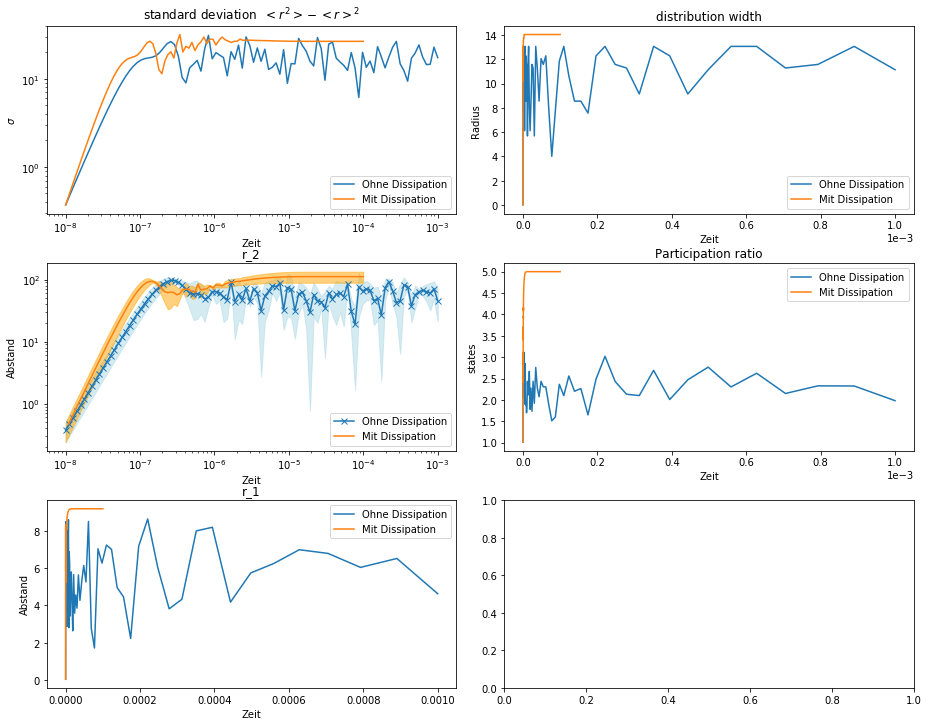

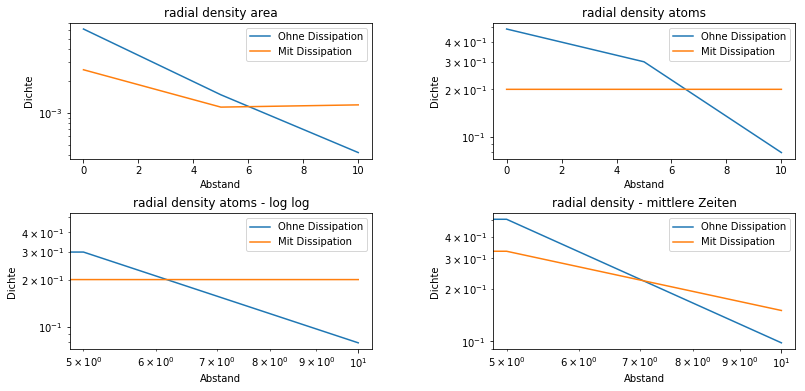

In [14]:
%matplotlib inline
d_r=2*r_b
x=np.arange(0,int(radius-d_r),d_r)



fig, axes = plt.subplots(3,2, figsize=(13,10))  # 2 rows, 2 columns
plt.tight_layout()  
plt.subplots_adjust(wspace=0.2)


#axes[1,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,0].set_title("standard deviation  "+ r"$<r^2>-<r>^2$")
axes[0,0].plot(times_exact, deviation_normal,label="Ohne Dissipation")
axes[0,0].plot(times, deviation_stepwise,label="Mit Dissipation")
axes[0,0].set_yscale("log")
axes[0,0].set_xscale("log")
axes[0,0].set_xlabel("Zeit")
axes[0,0].set_ylabel(r"$\sigma$")
axes[0,0].legend();


axes[0,1].set_title("distribution width")
axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,1].plot(times_exact,distribution_width_normal,label="Ohne Dissipation");
axes[0,1].plot(times,distribution_width_stepwise,label="Mit Dissipation");
axes[0,1].set_xlabel("Zeit")
axes[0,1].set_ylabel("Radius");
axes[0,1].legend();
fig.tight_layout()



axes[1,1].set_title("Participation ratio")
axes[1,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[1,1].plot(times_exact,ipr_normal,label="Ohne Dissipation");
axes[1,1].plot(times,ipr_stepwise,label="Mit Dissipation");
axes[1,1].set_xlabel("Zeit")
axes[1,1].set_ylabel("states");
axes[1,1].legend();


axes[1,0].set_title("r_2")
axes[1,0].set_yscale("log")
axes[1,0].set_xscale("log")
#axes[1,0].set_ylim(1,0.5*radius**2)
#axes[1,0].plot(times_exact,quad_func(times,0.1), label=r"$t^2$", color="black", linestyle = "--");
axes[1,0].fill_between(times_exact, r_2_normal-r_2_normal_S, r_2_normal+r_2_normal_S, color="lightblue", alpha=0.5)
axes[1,0].fill_between(times, r_2_stepwise-r_2_stepwise_S, r_2_stepwise+r_2_stepwise_S, color="orange", alpha=0.5)
axes[1,0].plot(times_exact,r_2_normal,label="Ohne Dissipation",marker="x");
axes[1,0].plot(times[1:],r_2_stepwise[1:],label="Mit Dissipation");
axes[1,0].set_xlabel("Zeit")
axes[1,0].set_ylabel("Abstand");
axes[1,0].legend();



axes[2,0].set_title("r_1")
#axes[2,0].set_yscale("log")
#axes[2,0].set_xscale("log")
#axes[2,0].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
#axes[2,0].set_ylim(1,radius)
axes[2,0].plot(times_exact,r_1_normal,label="Ohne Dissipation");
axes[2,0].plot(times,r_1_stepwise,label="Mit Dissipation");
axes[2,0].set_xlabel("Zeit")
axes[2,0].set_ylabel("Abstand");
axes[2,0].legend();


fig, axes = plt.subplots(2,2, figsize=(13,6))  # 2 rows, 2 columns
plt.subplots_adjust(wspace=0.4,hspace=0.4)


axes[0,0].set_title("radial density area")
axes[0,0].plot(x,n_intervall_inf_normal, label="Ohne Dissipation");
axes[0,0].plot(x,n_intervall_inf_stepwise,label="Mit Dissipation");
axes[0,0].set_xlabel("Abstand")
axes[0,0].set_ylabel("Dichte")
axes[0,0].set_yscale("log")
axes[0,0].legend();


axes[0,1].set_title("radial density atoms")
#axes[0,1].ticklabel_format(axis="x", style="scientific",scilimits=(4,-3))
axes[0,1].plot(x,density_inf_normal,label="Ohne Dissipation");
axes[0,1].plot(x,density_inf_stepwise,label="Mit Dissipation");
axes[0,1].set_xlabel("Abstand")
axes[0,1].set_ylabel("Dichte");
axes[0,1].set_yscale("log")
axes[0,1].legend();


axes[1,0].set_title("radial density atoms - log log")
axes[1,0].plot(x,density_inf_normal,label="Ohne Dissipation");
axes[1,0].plot(x,density_inf_stepwise,label="Mit Dissipation");
axes[1,0].set_xlabel("Abstand")
axes[1,0].set_ylabel("Dichte")
axes[1,0].set_yscale("log")
axes[1,0].set_xscale("log")
axes[1,0].legend();

axes[1,1].set_title("radial density - mittlere Zeiten")
axes[1,1].plot(x,density_normal,label="Ohne Dissipation");
axes[1,1].plot(x,density_stepwise,label="Mit Dissipation");
axes[1,1].set_xlabel("Abstand")
axes[1,1].set_ylabel("Dichte")
axes[1,1].set_yscale("log")
axes[1,1].set_xscale("log")
axes[1,1].legend();
